In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "svg"  # comment this line to use interactive plots
import plotly.graph_objects as go
import sys
import logging

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

sys.path.append("../components/paddock/")

%load_ext autoreload
%autoreload 2
from telemetry.influx import Influx
from telemetry.analyzer import Analyzer

from IPython.display import Image

pd.set_option("display.max_columns", None)

influx = Influx()
influx.laps_from_file("tracks.csv")
analyzer = Analyzer()

In [2]:
# (game, session, track, car) = "iRacing,1670222575,pocono 2016,Dallara IR18".split(",")
# (game, session, track, car) = "Automobilista 2,1671635969,Cascavel4:Cascavel2,Mercedes-Benz Actros".split(",")
# (game, session, track, car) = "iRacing,1670287161,spielberg gp,Porsche 911 GT3.R".split(",")
(game, session, track, car) = "iRacing,1670238139,spa up,Mercedes W12".split(",")
# (game, session, track, car) = "iRacing,1671643370,charlotte 2018 2019 rallycrosslong,Volkswagen Beetle GRC Lite".split(",")
# (game, session, track, car) = "iRacing,1670846922,nurburgring nordschleife,Porsche 911 GT3 Cup (992)".split(",")
# (game, session, track, car) = "Assetto Corsa (64 bit),1670215352,simtraxx_zeran:rally1,porsche_550_1500_rs_spyder_s1".split(",")
# (game, session, track, car) = "iRacing,1670351687,fuji gp,Ferrari 488 GT3 Evo 2020".split(",")
all_laps = influx.telemetry_for(game=game, track=track, car=car)

INFO:root:Processing iRacing spa up : 1670238139 -  1 : 6927 - 102.776634
INFO:root:Processing iRacing spa up : 1670238139 -  2 : 6928 - 103.518967
INFO:root:Processing iRacing spa up : 1670238752 - 15 : 6929 - 103.2187
INFO:root:Processing iRacing spa up : 1670238752 - 16 : 6928 - 103.874069
INFO:root:Processing iRacing spa up : 1670238752 - 18 : 6928 - 104.23233
INFO:root:Processing iRacing spa up : 1670238752 - 17 : 6928 - 104.3793
INFO:root:Processing iRacing spa up : 1670238752 - 19 : 6927 - 104.52977
INFO:root:Processing iRacing spa up : 1670238752 -  9 : 6928 - 104.801735
INFO:root:Processing iRacing spa up : 1670238752 - 20 : 6928 - 104.8196
INFO:root:Processing iRacing spa up : 1670238752 -  3 : 6929 - 104.863068


,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,Rpms,SpeedMs,SteeringAngle,Throttle,id
0,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.188248+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.922072,0.0,2.839830,6.0,0.0,0.0,65.220690,-0.010169,1.0,1670238139-1
1,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.204125+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.921332,0.0,5.017566,6.0,0.0,0.0,65.475400,-0.011137,1.0,1670238139-1
2,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.245310+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.922318,0.0,7.204051,6.0,0.0,0.0,65.731606,-0.012105,1.0,1670238139-1
3,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.263919+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.921825,0.0,9.398693,6.0,0.0,0.0,65.980370,-0.014527,1.0,1670238139-1
4,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.314962+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.922318,0.0,11.601985,6.0,0.0,0.0,66.228584,-0.014527,1.0,1670238139-1


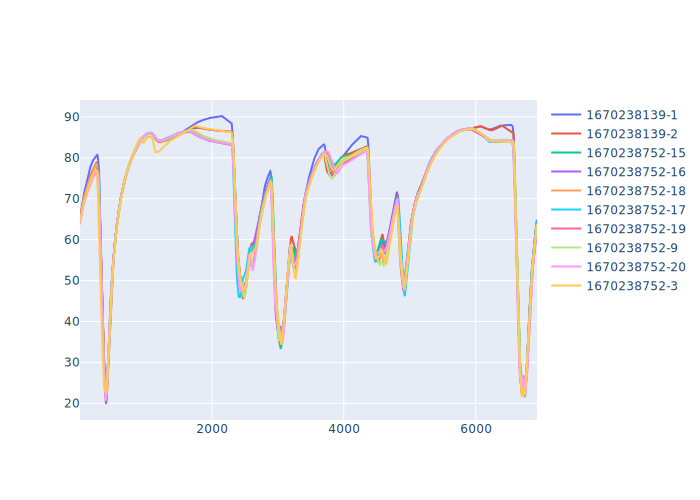

In [3]:
display(all_laps[0].head())
fig = go.Figure()

for df in all_laps:
    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["SpeedMs"],
        marker=dict(size=2),
        name=df["id"].iloc[0],
    )
fig.show()

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,Rpms,SpeedMs,SteeringAngle,Throttle,id
0,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.188248+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.922072,0.0,2.839830,6.0,0.0,0.0,65.220690,-0.010169,1.0,1670238139-1
1,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.204125+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.921332,0.0,5.017566,6.0,0.0,0.0,65.475400,-0.011137,1.0,1670238139-1
2,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.245310+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.922318,0.0,7.204051,6.0,0.0,0.0,65.731606,-0.012105,1.0,1670238139-1
3,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.263919+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.921825,0.0,9.398693,6.0,0.0,0.0,65.980370,-0.014527,1.0,1670238139-1
4,_result,0,2022-12-05 06:05:44.137256+00:00,2022-12-05 06:07:26.885396+00:00,2022-12-05 06:05:44.314962+00:00,Mercedes W12,1,iRacing,1670238139,Qualify,spa up,laps_cc,telegraf,crewchief/Jim/1670238139/iRacing/spa up/Merced...,Jim,0.0,0.922318,0.0,11.601985,6.0,0.0,0.0,66.228584,-0.014527,1.0,1670238139-1


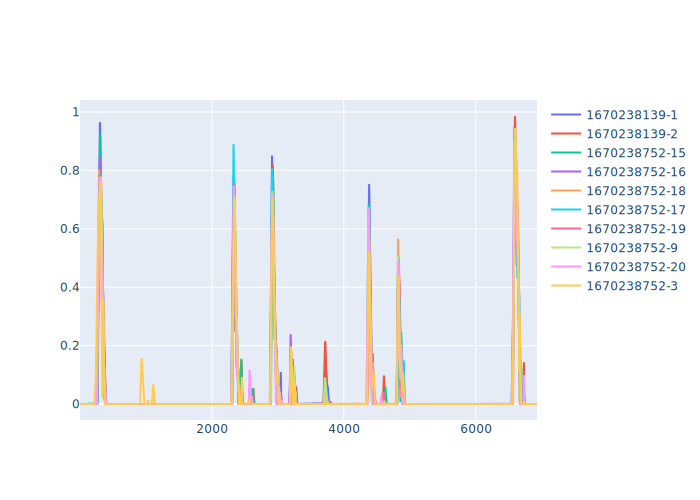

In [4]:
display(all_laps[0].head())
fig = go.Figure()

for df in all_laps:
    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["Brake"],
        marker=dict(size=2),
        name=df["id"].iloc[0],
    )
fig.show()

In [5]:
# remove laps that are too different from the others
print("checking for uncorrelated laps in SpeedMs")
laps = analyzer.remove_uncorrelated_laps(all_laps, column="SpeedMs")


checking for uncorrelated laps in SpeedMs


In [6]:
# get the max distance for each lap and select the max
max_distance = np.max([df["DistanceRoundTrack"].max() for df in laps])

display(f"max distance: {max_distance}")

'max distance: 6929.449'

number of minima 30 for lap 1670238139-1
number of minima 30 for lap 1670238139-2
number of minima 30 for lap 1670238752-15
number of minima 27 for lap 1670238752-16
number of minima 30 for lap 1670238752-18
number of minima 27 for lap 1670238752-17
number of minima 27 for lap 1670238752-19
number of minima 30 for lap 1670238752-9
number of minima 27 for lap 1670238752-20
number of minima 30 for lap 1670238752-3


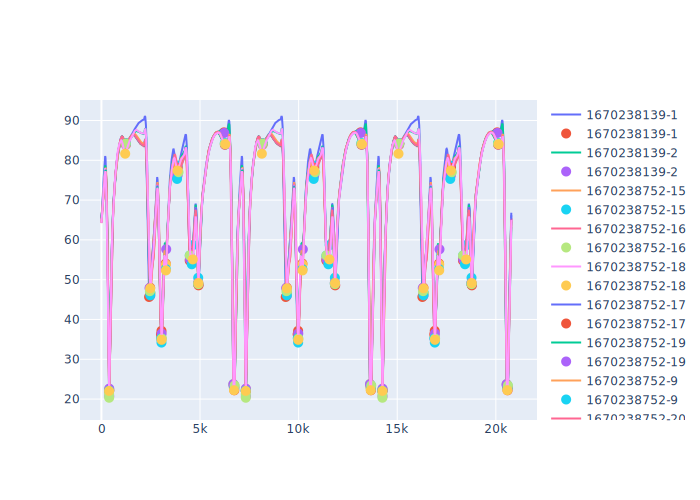

In [7]:
# create one plotly figure
fig = go.Figure()
all_minima = []
for df in laps:
    df = analyzer.drop_decreasing(df)
    df = analyzer.extend_lap(df)

    # smooth the laps
    window_length = 120  # 60 points corresponds to 1 seconds
    df["SpeedMs"] = savgol_filter(df["SpeedMs"], window_length, 2)

    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["SpeedMs"],
        mode="lines",
        marker=dict(size=2),
        name=df["id"].iloc[0],
    )
    minima = analyzer.local_minima(df, column="SpeedMs")
    # minima = analyzer.local_minima_off(df, column="SpeedMs")
    # min, max = analyzer.local_minima(df)
    # display(min)
    # display(max)
    print(f"number of minima {len(minima)} for lap {df['id'].iloc[0]}")
    all_minima.append(minima)

    fig.add_scatter(
        x=minima["DistanceRoundTrack"],
        y=minima["SpeedMs"],
        mode="markers",
        marker=dict(size=10),
        name=df["id"].iloc[0],
    )
    # break
fig.show()

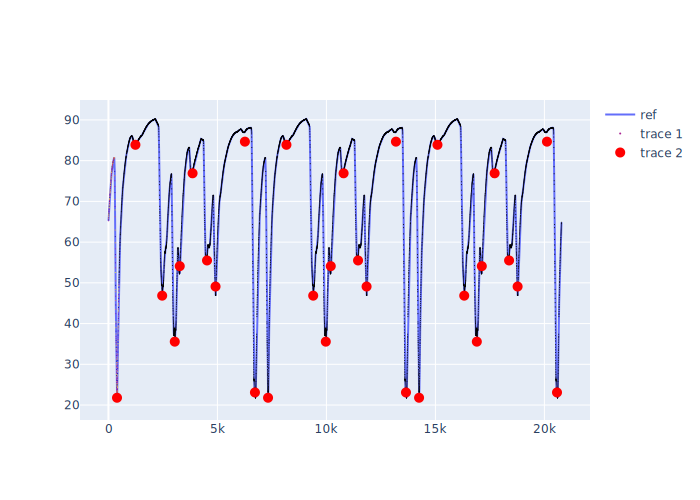

In [8]:
fig = go.Figure()
df = laps[0]
df = df[df["SpeedMs"] != 0]
df = analyzer.extend_lap(df)

fig.add_scatter(
    x=df["DistanceRoundTrack"], y=df["SpeedMs"], marker=dict(size=2), name="ref"
)

centroids_df, labels = analyzer.cluster(all_minima, field="SpeedMs")

# Plot the laps points with different colors for each cluster the colors are in lables
fig.add_scatter(
    y=df["SpeedMs"],
    x=df["DistanceRoundTrack"],
    mode="markers",
    marker=dict(size=1, color=labels),
)

# Add the centroids to the plot
fig.add_scatter(
    x=centroids_df["DistanceRoundTrack"],
    y=centroids_df["SpeedMs"],
    mode="markers+text",
    marker=dict(size=10, color="red"),
)

,SpeedMs,DistanceRoundTrack
0,21.787112,392.590779
1,83.892386,1236.447232
2,46.852169,2464.057455
3,35.559597,3042.001319
4,54.099258,3270.136088
5,76.898919,3859.011516
6,55.492338,4521.479768
7,49.093099,4912.717931
8,84.665046,6259.452104
9,23.091408,6720.158209


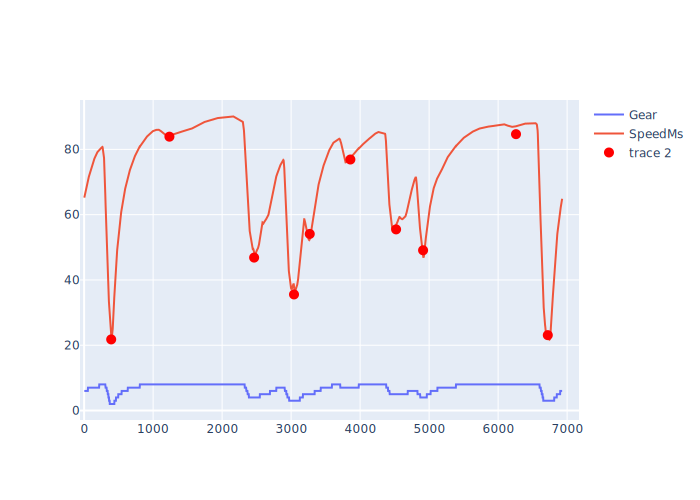

In [9]:
# display(centroids_df)
# sort the centroids by DistanceRoundTrack and reset the index
centroids_df = centroids_df.sort_values(by=["DistanceRoundTrack"])
centroids_df = centroids_df.reset_index(drop=True)
df = centroids_df.copy()

# apply modulo length to DistanceRoundTrack
df["DistanceRoundTrack"] = df["DistanceRoundTrack"].mod(max_distance)
# display(df)

# sort the centroids by DistanceRoundTrack and reset the index
df = df.sort_values(by=["DistanceRoundTrack"])
df = df.reset_index(drop=True)
# display(df)

n_clusters = int(len(df) / 3)
turns, labels = analyzer.cluster([df], field="SpeedMs", n_clusters=n_clusters)
turns = turns.sort_values(by=["DistanceRoundTrack"])
turns = turns.reset_index(drop=True)
display(turns)

fig = go.Figure()
df = laps[0].copy()
df = df[df["Gear"] != 0]

fig.add_scatter(
    x=df["DistanceRoundTrack"], y=df["Gear"], marker=dict(size=2), name="Gear"
)

# scale SpeedMs to 0-20
# df["SpeedMs"] = df["SpeedMs"] / 10
fig.add_scatter(
    x=df["DistanceRoundTrack"], y=df["SpeedMs"], marker=dict(size=2), name="SpeedMs"
)


# Add the turns to the plot
fig.add_scatter(
    x=turns["DistanceRoundTrack"],
    y=turns["SpeedMs"],
    mode="markers+text",
    marker=dict(size=10, color="red"),
)

In [10]:
# for each turn
for i in range(len(turns)):
    # get the distance of the turn
    distance = turns["DistanceRoundTrack"].iloc[i]
    # get the speed of the turn
    speed = turns["SpeedMs"].iloc[i]

    if i == 0:
        prev_distance = turns["DistanceRoundTrack"].iloc[len(turns) - 1]
        next_distance = turns["DistanceRoundTrack"].iloc[i + 1]
        d = distance + (max_distance - prev_distance)
        start = (distance - d / 2) % max_distance
        end = (distance + (next_distance - distance) / 2) % max_distance
    elif i == len(turns) - 1:
        prev_distance = turns["DistanceRoundTrack"].iloc[i - 1]
        next_distance = turns["DistanceRoundTrack"].iloc[0]
        start = (distance - (distance - prev_distance) / 2) % max_distance
        d = (max_distance - distance) + next_distance
        end = (distance + d / 2) % max_distance
    else:
        prev_distance = turns["DistanceRoundTrack"].iloc[i - 1]
        next_distance = turns["DistanceRoundTrack"].iloc[i + 1]
        start = (distance - (distance - prev_distance) / 2) % max_distance
        end = (distance + (next_distance - distance) / 2) % max_distance

    gears = []
    for df in laps:
        df = df.copy()
        df = df[df["Gear"] != 0]
        # get the gear of the turn
        # Create the boolean indexing mask
        min = (distance - 50) % max_distance
        max = (distance + 50) % max_distance
        mask = (df["DistanceRoundTrack"] >= min) & (df["DistanceRoundTrack"] <= max)
        # select all points in df where DistanceRoundTrack is between min and max
        gear = df.loc[mask]["Gear"].min()
        # print(gear)
        gears.append(gear)

    # find median gear
    # display(gears)
    gear = int(np.median(gears))
    print(
        f"turn {i} at distance {distance} with speed {speed} and gear {gear}, start: {start}, end: {end}"
    )

turn 0 at distance 392.5907786000007 with speed 21.78711188907667 and gear 2, start: 91.64999380000017, end: 814.5190053000006
turn 1 at distance 1236.4472320000004 with speed 83.89238602110379 and gear 8, start: 814.5190053000006, end: 1850.2523435000003
turn 2 at distance 2464.057455 with speed 46.85216945534922 and gear 4, start: 1850.2523435000003, end: 2753.0293870000005
turn 3 at distance 3042.001319000001 with speed 35.55959714108988 and gear 3, start: 2753.0293870000005, end: 3156.0687035
turn 4 at distance 3270.1360879999997 with speed 54.099258220432425 and gear 5, start: 3156.0687035, end: 3564.5738020000003
turn 5 at distance 3859.011516000001 with speed 76.89891854359645 and gear 8, start: 3564.5738020000003, end: 4190.24564209091
turn 6 at distance 4521.479768181819 with speed 55.49233786251519 and gear 5, start: 4190.24564209091, end: 4717.09884959091
turn 7 at distance 4912.717931 with speed 49.09309895516651 and gear 4, start: 4717.09884959091, end: 5586.0850175000005
